In [1]:
!nvidia-smi

Fri Dec 13 03:35:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
uploaded = files.upload()

Saving artists_all.csv to artists_all.csv


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d karentree/artchallenge-118-artists-classification
!unzip /content/artchallenge-118-artists-classification.zip

100% 2.96G/2.97G [00:43<00:00, 28.7MB/s]
100% 2.97G/2.97G [00:44<00:00, 72.4MB/s]
Archive:  /content/artchallenge-118-artists-classification.zip
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_1.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_10.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_11.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_12.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_13.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_14.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_15.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_16.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_17.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_18.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_19.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_2.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdo

# **Data** **Preparation**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

Using TensorFlow backend.


In [8]:
artists = pd.read_csv("artists_all.csv")
artists = artists.iloc[:,1:]
artists

,name,years,genre,nationality,paintings,number_of_genre
0,Amedeo Modigliani,1884 - 1920,['Expressionism'],['Italian'],193,1
1,Vasiliy Kandinskiy,1866 - 1944,"['Expressionism', 'Abstractionism']",['Russian'],88,2
2,Diego Rivera,1886 - 1957,"['Social Realism', 'Muralism']",['Mexican'],70,2
3,Claude Monet,1840 - 1926,['Impressionism'],['French'],73,1
4,Rene Magritte,1898 - 1967,"['Surrealism', 'Impressionism']",['Belgian'],194,2
...,...,...,...,...,...,...
113,Nikolai Ge,1831 – 1894,['Realism'],['Russian'],43,1
114,Robert Campin,1375 – 1444,['Northern Renaissance'],['Flemish'],42,1
115,Fyodor Rokotov,1736 – 1808,['Rococo'],['Russian'],32,1
116,Rockwell Kent,1882 – 1971,['Realism'],['American'],51,1


In [0]:
artists = artists[artists['paintings'] > 200]
artists = artists.reset_index()
artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)
class_weights = artists['class_weight'].to_dict()

In [0]:
# Explore images of top artists
images_dir = '/content/images'
artists_dirs = os.listdir(images_dir)
artists_name = artists['name'].str.replace(' ', '_').values
# change Albrecht_Dürer to Albrecht_DuтХа├кrer
artists_name = ['Albrecht_DuтХа├кrer' if x == 'Albrecht_Dürer' else x for x in artists_name]

In [11]:
# check if image directory is valid for all artists
for name in artists_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/images/Vincent_van_Gogh
Found --> /content/images/Pablo_Picasso
Found --> /content/images/Pierre-Auguste_Renoir
Found --> /content/images/Francisco_Goya
Found --> /content/images/Albrecht_DuтХа├кrer
Found --> /content/images/Alfred_Sisley
Found --> /content/images/Marc_Chagall
Found --> /content/images/Edgar_Degas
Found --> /content/images/Rembrandt
Found --> /content/images/Titian
Found --> /content/images/Paul_Gauguin
Found --> /content/images/Ivan_Shishkin
Found --> /content/images/Nicholas_Roerich
Found --> /content/images/Andrew_Wyeth
Found --> /content/images/Ivan_Aivazovsky
Found --> /content/images/Zinaida_Serebriakova
Found --> /content/images/Egon_Schiele
Found --> /content/images/Alphonse_Mucha
Found --> /content/images/Edward_Burne-Jones
Found --> /content/images/Gustave_Moreau
Found --> /content/images/Paul_Signac
Found --> /content/images/Alexandre_Benois
Found --> /content/images/Aleksandr_Deyneka
Found --> /content/images/Lucas_Cranach_the_Elder
Found

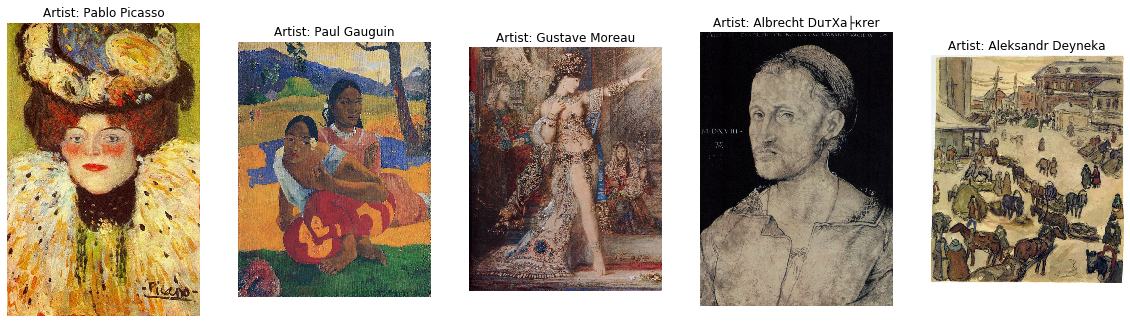

In [12]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_name)
    # get a random image in the 
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    #print(random_image)
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')
    
plt.show()

# **Data** **Augmentation**

In [13]:
batch_size = 12
train_input_shape = (224, 224, 3)
n_classes = artists.shape[0]
print(n_classes)
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical', # 118 class
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_name
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_name
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

25
Found 7144 images belonging to 25 classes.
Found 1772 images belonging to 25 classes.
Total number of batches = 595 and 147


# **VGG** **Model**

In [0]:
from keras.applications import vgg16
import numpy as np
import os
import time
#from vgg16 import VGG16
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
#from imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

In [21]:
image_input = Input(shape=(224, 224, 3))
model = vgg16.VGG16(input_tensor=image_input,include_top=True,weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
np.random.seed(1000)
n_class = 25
num_classes = n_class
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
#model.add(out)
#model.summary()
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
custom_vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
for layer in custom_vgg_model.layers[:-3]:
	layer.trainable = False

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [25]:
epochs = 30
csv_logger = CSVLogger("VGG16_history_artists_200_log.csv", append=True)
history1 = custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    shuffle =True,
    verbose=1,
    workers=16,
    use_multiprocessing=True,
    callbacks = [reduce_lr,csv_logger]
     )

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


595/595 [==============================] - 210s 353ms/step - loss: 2.2136 - acc: 0.3510 - val_loss: 1.7878 - val_acc: 0.4728
Epoch 2/30
595/595 [==============================] - 204s 343ms/step - loss: 1.4341 - acc: 0.5744 - val_loss: 1.4125 - val_acc: 0.5824
Epoch 3/30
595/595 [==============================] - 204s 344ms/step - loss: 1.1339 - acc: 0.6584 - val_loss: 1.1246 - val_acc: 0.6790
Epoch 4/30
595/595 [==============================] - 205s 345ms/step - loss: 0.9756 - acc: 0.7057 - val_loss: 1.2605 - val_acc: 0.6330
Epoch 5/30
595/595 [==============================] - 205s 345ms/step - loss: 0.8317 - acc: 0.7508 - val_loss: 1.0264 - val_acc: 0.6938
Epoch 6/30
595/595 [==============================] - 204s 343ms/step - loss: 0.7050 - acc: 0.7818 - val_loss: 1.0241 - val_acc: 0.7000
Epoch 7/30
595/595 [==============================] - 204s 343ms/step - loss: 0.6254 - acc: 0.8069 - val_loss: 1.0328 - val_acc: 0.6949
Epoch 8/30
595/595 [==============================] - 203s 

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/VGG16_history_artists_200_log.csv /content/gdrive/My\ Drive/

In [0]:
from keras.models import load_model

path = "/content/gdrive/My Drive/VGG16_model_artists_200.h5" 
custom_vgg_model.save(path)

# **Summary** **Output**

In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists.name.to_list()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists.name.to_list()))

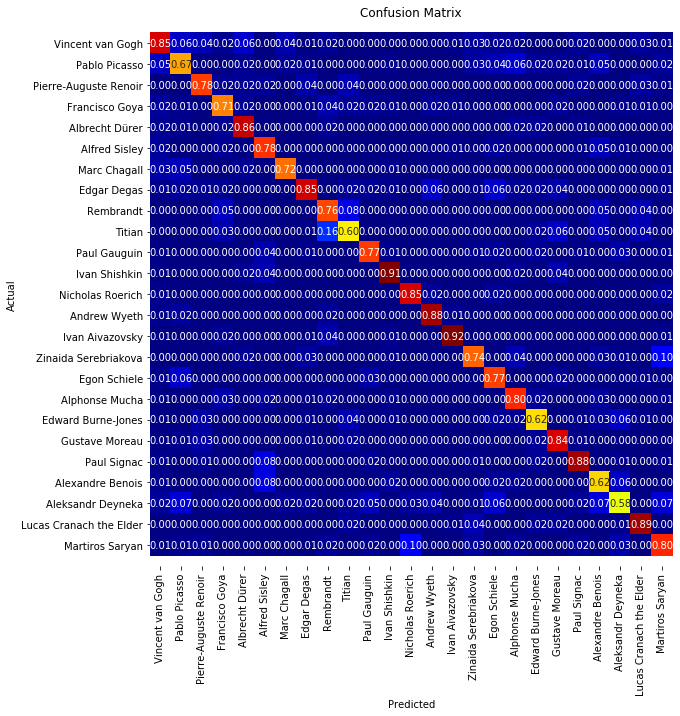

Classification Report:
                         precision    recall  f1-score   support

       Vincent van Gogh       0.75      0.85      0.80       175
          Pablo Picasso       0.67      0.67      0.67        85
  Pierre-Auguste Renoir       0.84      0.78      0.81        67
         Francisco Goya       0.75      0.71      0.73        58
         Albrecht Dürer       0.85      0.86      0.85        65
          Alfred Sisley       0.74      0.78      0.76        51
           Marc Chagall       0.89      0.72      0.80        47
            Edgar Degas       0.83      0.85      0.84       140
              Rembrandt       0.70      0.76      0.73        51
                 Titian       0.70      0.60      0.65        50
           Paul Gauguin       0.84      0.77      0.81        62
          Ivan Shishkin       0.87      0.91      0.89        81
       Nicholas Roerich       0.87      0.85      0.86        39
           Andrew Wyeth       0.87      0.88      0.88        52
 

In [31]:
showClassficationReport_Generator(custom_vgg_model, valid_generator, STEP_SIZE_VALID)

Text(0, 0.5, 'accuracy')

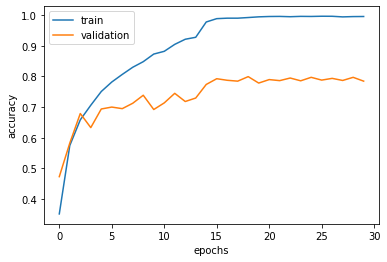

In [32]:
import matplotlib.pyplot as plt

plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')